# Calculation of square of a domain by Monter Carlo method

First, import my utility function:

In [1]:
# %load monter_carlo_method.py
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Tuple
from dataclasses import dataclass
from matplotlib.ticker import FuncFormatter
from numpy import ndarray


class Region(object):
    """
    Represents a geometric region defined by a boundary equation of the form:
    |x - xi|^pi + |y - yi|^pi = ci
    """

    def __init__(self, xi: float, yi: float, pi: float, ci: float):
        # Initialize the Region with the equation parameters
        self.xi = xi  # x-coordinate of the reference point
        self.yi = yi  # y-coordinate of the reference point
        self.pi = pi  # Power in the boundary equation
        self.ci = ci  # Constant in the boundary equation


@dataclass
class MCResult:
    """
    Stores the results from a Monte Carlo simulation for estimating area.
    """
    m: int  # Count of points within the region
    N: int  # Total number of sampled points
    m_N: float  # Ratio of points within the region
    S0: float  # Estimated area of the region
    D_eta: float  # Variance of the Bernoulli random variable
    accuracy_of_p_epsilon: float  # Precision of the probability estimate
    abs_accuracy_of_S0: float  # Absolute accuracy of the estimated area
    rel_accuracy_of_S0: float  # Relative accuracy of the estimated area
    CI: Tuple  # Confidence interval for the area estimate
    fall_points: np.ndarray  # Array of sampled points with inside/outside status


class MonterCarloSolution(object):

    def __init__(self, regions: List[Region]):
        self.regions = regions
        self.R = self.calculate_R()
        self.S = self.calculate_R_area()

    def fitting(self, max_N: int = 100, confidence=None) -> List[MCResult]:
        results = list()
        gen_points = self.generating_random_points(self.R, max_N)
        for N in range(1, max_N + 1):
            result = self.calculate(N, confidence, gen_points[:N])
            results.append(
                result
            )
        return results

    def calculate(self, N: int = 10, confidence: str = "95%", gen_points=None) -> MCResult:
        if gen_points is None:
            gen_points = self.generating_random_points(self.R, N)
        fall_points, m = self.find_fall_is_points_in_regions(self.regions, gen_points)
        m_N = m / N
        S0 = m_N * self.S
        D_eta = self.calculate_D_eta(m_N)
        epsilon = self.calculate_accuracy_of_p_epsilon(D_eta, N, confidence)
        abs_accuracy = self.calculate_abs_accuracy_of_S(epsilon, self.S)
        rel_accuracy = self.calculate_rel_accuracy_of_S0(abs_accuracy, S0)
        CI = (round(S0 - abs_accuracy, 5), round(S0 + abs_accuracy, 5))

        return MCResult(m=int(m), N=N, m_N=m_N, S0=S0, D_eta=D_eta, accuracy_of_p_epsilon=epsilon,
                        abs_accuracy_of_S0=abs_accuracy, rel_accuracy_of_S0=rel_accuracy, CI=CI,
                        fall_points=fall_points)

    def visual_regions(self, result: MCResult = None, padding: float = 0.1, fill: bool = True, dpi=80) -> None:
        x_min, x_max, y_min, y_max = self.R
        # padding
        x_padding = (x_max - x_min) * padding
        y_padding = (y_max - y_min) * padding

        x_min_padded, x_max_padded = x_min - x_padding, x_max + x_padding
        y_min_padded, y_max_padded = y_min - y_padding, y_max + y_padding

        # setting pixel
        plt.figure(figsize=(8, 8), dpi=dpi)

        x = np.linspace(x_min_padded, x_max_padded, 500)
        y = np.linspace(y_min_padded, y_max_padded, 500)
        X, Y = np.meshgrid(x, y)

        colors = ["blue"] if fill else ['yellow', 'green', 'cyan', 'blue', 'red', 'magenta', 'black']

        alpha = 1.0 if fill else 0.5

        for i, region in enumerate(self.regions):
            Z = (np.abs(X - region.xi) ** region.pi + np.abs(Y - region.yi) ** region.pi) - region.ci
            # fill
            color = colors[i % len(colors)]
            plt.contourf(X, Y, Z, levels=[-region.ci, 0], colors=[color], alpha=alpha)
            # add text
            if not fill:
                plt.text(region.xi, region.yi, f'D{i + 1}', horizontalalignment='center', verticalalignment='center', )

        if result is not None:
            # Filter points that are inside the regions (indicated by the third column being 1)
            inside_points = result.fall_points[result.fall_points[:, 2] == 1]
            outside_points = result.fall_points[result.fall_points[:, 2] == 0]

            # Plot inside points with red 'o'
            plt.scatter(inside_points[:, 0], inside_points[:, 1], color='red', marker='o', s=10)

            # Plot outside points with black 'x'
            plt.scatter(outside_points[:, 0], outside_points[:, 1], color='black', marker='x', s=10)

        if result is not None:
            # Add MCResult metrics to the plot as text
            result_text = (
                f'N = {result.N}\n'
                f'm/N = {result.m_N}\n'
                f'D_eta = {round(result.D_eta, 6)}\n'
                f'S = {round(self.S, 6)}, S0 = {round(result.S0, 6)}\n'
                f'abs.accuracy of S0 = {round(result.abs_accuracy_of_S0, 6)}\n'
                f'rel.accuracy of S0 = {round(result.rel_accuracy_of_S0, 6)}%\n'
                f'90% CI = {result.CI}'
            )
            plt.text(x_max_padded, y_max_padded, result_text, horizontalalignment='right', verticalalignment='top',
                     bbox=dict(facecolor='white', alpha=0.5))

        # Added padding
        plt.plot([x_min, x_max, x_max, x_min, x_min], [y_min, y_min, y_max, y_max, y_min], 'g--')

        plt.xlim(x_min_padded, x_max_padded)
        plt.ylim(y_min_padded, y_max_padded)
        plt.xlabel('x')
        plt.ylabel('y')
        plt.title('Filled Plot of Regions D1, D2, and D3 with Correct Aspect Ratio')
        plt.grid(True)
        plt.gca().set_aspect('equal', adjustable='box')
        plt.show()

    def calculate_R_area(self) -> float:
        x_min, x_max, y_min, y_max = self.R
        # Calculate the width and height of the rectangle
        width = x_max - x_min
        height = y_max - y_min
        # Calculate the area
        area = width * height

        return area

    def calculate_R(self) -> Tuple:
        x_min = float('inf')
        x_max = float('-inf')
        y_min = float('inf')
        y_max = float('-inf')

        for region in self.regions:
            x_min = min(x_min, region.xi - region.ci ** (1 / region.pi))
            x_max = max(x_max, region.xi + region.ci ** (1 / region.pi))
            y_min = min(y_min, region.yi - region.ci ** (1 / region.pi))
            y_max = max(y_max, region.yi + region.ci ** (1 / region.pi))

        return x_min, x_max, y_min, y_max

    @staticmethod
    def calculate_D_eta(m_n: float) -> float:
        return (1 - m_n) * m_n

    @staticmethod
    def calculate_accuracy_of_p_epsilon(D_eta: float, N: int, confidence: str = None) -> float:
        confidence_level_table = {
            None: 1.0,
            "90%": 1.65,
            "95%": 1.96,
            "99%": 3.0,
        }
        z = confidence_level_table.get(confidence)
        if z is None:
            raise ValueError(f"Unsupported confidence level: {confidence}")
        return z * (D_eta / np.sqrt(N))

    @staticmethod
    def calculate_abs_accuracy_of_S(epsilon: float, S: float) -> float:
        return S * epsilon

    @staticmethod
    def calculate_rel_accuracy_of_S0(abs_accuracy: float, S0: float) -> float:
        return (abs_accuracy / S0) * 100

    @staticmethod
    def find_fall_is_points_in_regions(regions: List[Region], points: np.ndarray) -> Tuple[ndarray, ndarray]:
        # Initialize an array to store the result with an extra third column for the indicator
        points_with_indicator = np.hstack((points, np.zeros((points.shape[0], 1))))
        # Check each point against all regions
        for i, point in enumerate(points):
            for region in regions:
                # Calculate the region function value for the point
                if (np.abs(point[0] - region.xi) ** region.pi + np.abs(point[1] - region.yi) ** region.pi) <= region.ci:
                    # If the point satisfies the region condition, mark it as inside (1)
                    points_with_indicator[i, 2] = 1
                    break  # No need to check other regions if it's already inside one

        # Count how many points fall inside the union of regions
        points_inside = np.sum(points_with_indicator[:, 2])

        return points_with_indicator, points_inside

    @staticmethod
    def generating_random_points(rect: Tuple, n: int = 1000) -> np.ndarray:
        x_min, x_max, y_min, y_max = rect
        random_points = np.random.rand(n, 2)
        random_points[:, 0] = random_points[:, 0] * (x_max - x_min) + x_min
        random_points[:, 1] = random_points[:, 1] * (y_max - y_min) + y_min

        return random_points

    @staticmethod
    def plot_relative_accuracy(results: List[MCResult]) -> None:
        # Extract sample sizes and relative accuracies
        sample_sizes = [result.N for result in results]
        relative_accuracies = [result.rel_accuracy_of_S0 for result in results]

        # Create the plot
        plt.figure(figsize=(10, 6))
        plt.plot(sample_sizes, relative_accuracies, linestyle='-', color='black')  # Line

        # Set the title and labels
        plt.title('The relative accuracy of the square S0 as a function of sample size N')
        plt.xlabel('Sample Size N')
        plt.ylabel('Relative Accuracy of S0 (%)')

        # Formatter to add a percentage sign
        def to_percent(y, position):
            # The percent symbol needs escaping in python strings
            s = str(y)
            return s + '%'

        # Create the formatter using the function to_percent
        formatter = FuncFormatter(to_percent)

        # Set the formatter
        plt.gca().yaxis.set_major_formatter(formatter)

        # Show grid
        plt.grid(True)

        # Show the plot
        plt.show()

    @staticmethod
    def check_local_value(m_n, S, N, conf):
        eta = MonterCarloSolution.calculate_D_eta(m_n)
        eps = MonterCarloSolution.calculate_accuracy_of_p_epsilon(eta, N, conf)
        abs_acc = MonterCarloSolution.calculate_abs_accuracy_of_S(eps, S)
        print(f"D_eta = {eta}")
        print(f"eps = {eps}")
        print(f"abs_acc = {abs_acc}")

## Show my data From Worksheet3

![my_data.png](my_data.png)

Equation of domains' boundaries:
$$D_1 : |x|^{2.1} + |y + 0.5|^{2.1} = 2$$

$$D_2 : |x - 1.6|^{2.1} + |y - 0.5|^{2.1} = 1.0$$

$$D_3 : |x - 0.5|^{2.6} + |y|^{2.6} = 1$$

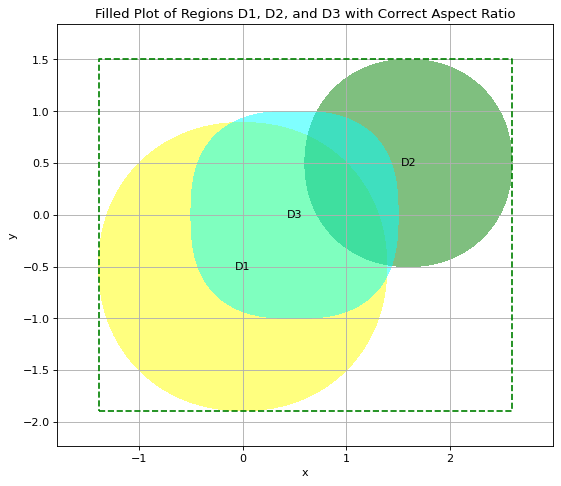

In [2]:
# verification
regions = [
    Region(0, -0.5, 2.1, 2),  # D1
    Region(1.6, 0.5, 2.1, 1), # D2
    Region(0.5, 0, 2.6, 1),   # D3
]
singleton = MonterCarloSolution(regions)
singleton.visual_regions(padding=0.1, fill=False)

Figure Domain D—the union of domains D1, D2, D3

In [3]:
num_of_samples = 1000
confidence = "90%"
results = singleton.fitting(num_of_samples, confidence)

## Solution

Here is the solution

In [4]:
singleton.R, singleton.S

((-1.3910656192458295, 2.6, -1.8910656192458295, 1.5), 13.533965405578599)

We can find $R$, $R =[-1.3910656192458295, 2.6] \times [-1.8910656192458295, 1.5]$, square $S=13.533965405578599$

In [5]:
checkpoints = [10, 25, 60, 150, 400, 1000]

In [6]:
for ckt in checkpoints:
    result = results[ckt - 1]
    print(f"N = {result.N}")
    print(f"S0 = {result.S0}")
    print(f"epsilon = {result.accuracy_of_p_epsilon}")
    print(f"abs.accuracy of S0 = {result.abs_accuracy_of_S0}")
    print(f"rel.accuracy of S0 = {round(result.rel_accuracy_of_S0, 4)}%")
    print(f"="*30)

N = 10
S0 = 10.827172324462879
epsilon = 0.08348413022844518
abs.accuracy of S0 = 1.1298713304265957
rel.accuracy of S0 = 10.4355%
N = 25
S0 = 9.74445509201659
epsilon = 0.066528
abs.accuracy of S0 = 0.900387650502333
rel.accuracy of S0 = 9.24%
N = 60
S0 = 10.150474054183949
epsilon = 0.03994014075776398
abs.accuracy of S0 = 0.5405484833095175
rel.accuracy of S0 = 5.3254%
N = 150
S0 = 9.022643603719064
epsilon = 0.02993820796734996
abs.accuracy of S0 = 0.4051826709351319
rel.accuracy of S0 = 4.4907%
N = 400
S0 = 9.270766302821341
epsilon = 0.017801437499999996
abs.accuracy of S0 = 0.24092403929456951
rel.accuracy of S0 = 2.5987%
N = 1000
S0 = 9.08129078714324
epsilon = 0.011518670690688335
abs.accuracy of S0 = 0.15589329064602805
rel.accuracy of S0 = 1.7166%


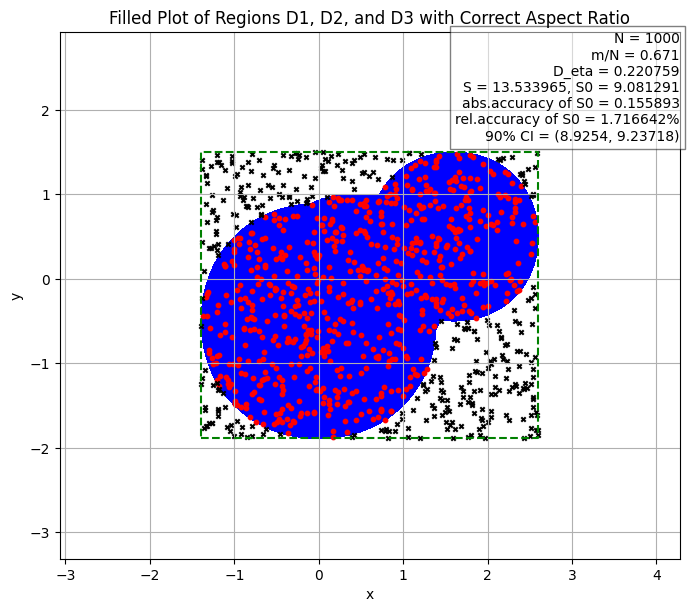

In [7]:
# Show the result
singleton.visual_regions(result, fill=True, padding=0.42, dpi=100)

In [8]:
last = results[-1]
print(f"S0 = {last.S0}")
print(f"absolute accuracy = {last.abs_accuracy_of_S0}")
print(f"relative accuracy = {round(last.rel_accuracy_of_S0, 6)}%")
print(f"CI = {last.CI}")

S0 = 9.08129078714324
absolute accuracy = 0.15589329064602805
relative accuracy = 1.716642%
CI = (8.9254, 9.23718)


| N    | $S_0$          | accuracy of $p(\epsilon)$         | abs.accuracy of $S_0$ | rel.accuracy of $S_0$ |
|------|-------------|-----------|--------------------|--------------------|
| 10   | 10.82717232 | 0.08348413| 1.129871330       | 10.4355%           |
| 25   | 9.744455092 | 0.066528  | 0.900387651       | 9.24%              |
| 60   | 10.15047405 | 0.03994014| 0.540548483       | 5.3254%            |
| 150  | 9.022643604 | 0.02993821| 0.405182671       | 4.4907%            |
| 400  | 9.270766303 | 0.01780144| 0.240924039       | 2.5987%            |
| 1000 | 9.081290787 | 0.01151867| 0.155893291       | 1.7166%            |



The relative accuracy of the square $S_0$ equals $1.7166%$, so this value enough for the task.As the absolute accuracy for $N=1000$, and confidence probability $90%$ equals $0.155893291$, true value of the $S_0$ belongs to
    
$$ (9.081290787 - 0.155893291, 9.081290787 + 0.155893291) = (8.9254, 9.23718) $$
    
with probability $0.90$. $S_0 < 8.9254$ or $S_0 > 9.23718$  with probability $1 - 0.9 = 0.1$.

The dependence of the relative accuracy of the square $S_0$ on sample size is shown in Figure below

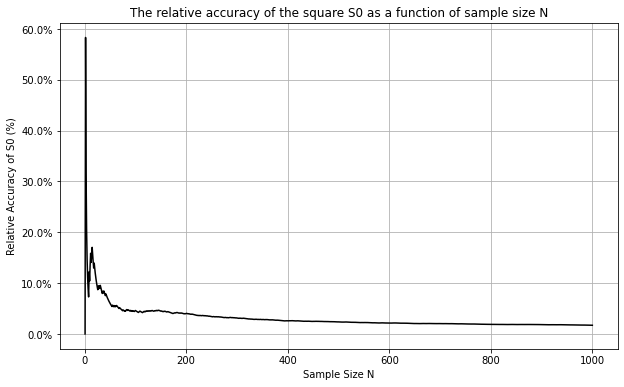

In [9]:
singleton.plot_relative_accuracy(results)

The relative accuracy of the square $S_0$ as a function of sample size $N$